In [2]:
# Install necessary packages
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install tqdm
!pip install pandas
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Define paths - adjust these based on your Kaggle dataset structure
base_path = '/kaggle/input/cattle-disease-detection-v11i-yolov11'
train_img_path = os.path.join(base_path, 'train', 'images')
train_label_path = os.path.join(base_path, 'train', 'labels')
valid_img_path = os.path.join(base_path, 'valid', 'images')
valid_label_path = os.path.join(base_path, 'valid', 'labels')

# Check if paths exist
print("Train images path exists:", os.path.exists(train_img_path))
print("Train labels path exists:", os.path.exists(train_label_path))
print("Valid images path exists:", os.path.exists(valid_img_path))
print("Valid labels path exists:", os.path.exists(valid_label_path))

# Count number of files
print("\nNumber of training images:", len(os.listdir(train_img_path)))
print("Number of training labels:", len(os.listdir(train_label_path)))
print("Number of validation images:", len(os.listdir(valid_img_path)))
print("Number of validation labels:", len(os.listdir(valid_label_path)))

Train images path exists: True
Train labels path exists: True
Valid images path exists: True
Valid labels path exists: True

Number of training images: 7080
Number of training labels: 7080
Number of validation images: 466
Number of validation labels: 466


In [5]:
import yaml

# Read the data.yaml file
yaml_path = os.path.join(base_path, 'data.yaml')
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Get class names
class_names = data['names']
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['Infected_Foot_Image', 'Mouth Disease Infected', 'Normal_Healthy_Cow', 'Normal_Mouth_Image', 'lumpy skin']
Number of classes: 5


In [6]:
class CattleDiseaseDataset(Dataset):
    def __init__(self, img_dir, label_dir, class_names, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.class_names = class_names
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get corresponding label file
        label_name = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.label_dir, label_name)
        
        # Read label file - we'll use the first class found in the image
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if lines:
                # Get the first object's class in the image
                class_id = int(lines[0].split()[0])
            else:
                # If no objects, we'll assign a default class (you might want to handle this differently)
                class_id = 0
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            
        return image, class_id

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CattleDiseaseDataset(train_img_path, train_label_path, class_names, transform=transform)
valid_dataset = CattleDiseaseDataset(valid_img_path, valid_label_path, class_names, transform=transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")

Training batches: 222
Validation batches: 15


In [8]:
class CattleDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(CattleDiseaseCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CattleDiseaseCNN(num_classes=num_classes).to(device)
print(model)

CattleDiseaseCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                sz
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if it's the best accuracy on validation set
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    return model

In [11]:
# Train the model
num_epochs = 20
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 1.3300 Acc: 0.6205


valid: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


valid Loss: 1.8764 Acc: 0.4335

Epoch 2/20
----------


train: 100%|██████████| 222/222 [01:17<00:00,  2.87it/s]


train Loss: 1.1358 Acc: 0.6274


valid: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


valid Loss: 1.6001 Acc: 0.4335

Epoch 3/20
----------


train: 100%|██████████| 222/222 [01:18<00:00,  2.83it/s]


train Loss: 1.1027 Acc: 0.6278


valid: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


valid Loss: 1.6133 Acc: 0.4335

Epoch 4/20
----------


train: 100%|██████████| 222/222 [01:18<00:00,  2.81it/s]


train Loss: 1.0774 Acc: 0.6281


valid: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


valid Loss: 1.3478 Acc: 0.4335

Epoch 5/20
----------


train: 100%|██████████| 222/222 [01:19<00:00,  2.80it/s]


train Loss: 1.0512 Acc: 0.6302


valid: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


valid Loss: 1.4903 Acc: 0.4764

Epoch 6/20
----------


train: 100%|██████████| 222/222 [01:18<00:00,  2.81it/s]


train Loss: 0.9951 Acc: 0.6449


valid: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


valid Loss: 1.1426 Acc: 0.5215

Epoch 7/20
----------


train: 100%|██████████| 222/222 [01:19<00:00,  2.80it/s]


train Loss: 0.9725 Acc: 0.6501


valid: 100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


valid Loss: 1.1705 Acc: 0.5386

Epoch 8/20
----------


train: 100%|██████████| 222/222 [01:19<00:00,  2.80it/s]


train Loss: 0.9593 Acc: 0.6542


valid: 100%|██████████| 15/15 [00:02<00:00,  5.02it/s]


valid Loss: 1.2000 Acc: 0.5300

Epoch 9/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.76it/s]


train Loss: 0.9384 Acc: 0.6599


valid: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


valid Loss: 1.0567 Acc: 0.5858

Epoch 10/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.9129 Acc: 0.6669


valid: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


valid Loss: 1.0545 Acc: 0.5858

Epoch 11/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8795 Acc: 0.6732


valid: 100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


valid Loss: 1.0408 Acc: 0.5837

Epoch 12/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8732 Acc: 0.6749


valid: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


valid Loss: 1.0558 Acc: 0.5773

Epoch 13/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8726 Acc: 0.6785


valid: 100%|██████████| 15/15 [00:02<00:00,  5.02it/s]


valid Loss: 1.0410 Acc: 0.5901

Epoch 14/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8653 Acc: 0.6782


valid: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


valid Loss: 1.0491 Acc: 0.5858

Epoch 15/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8595 Acc: 0.6802


valid: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


valid Loss: 1.0388 Acc: 0.5987

Epoch 16/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8567 Acc: 0.6804


valid: 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


valid Loss: 1.0380 Acc: 0.5987

Epoch 17/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8556 Acc: 0.6828


valid: 100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


valid Loss: 1.0376 Acc: 0.5987

Epoch 18/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.74it/s]


train Loss: 0.8560 Acc: 0.6819


valid: 100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


valid Loss: 1.0363 Acc: 0.5987

Epoch 19/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.74it/s]


train Loss: 0.8554 Acc: 0.6798


valid: 100%|██████████| 15/15 [00:02<00:00,  5.01it/s]


valid Loss: 1.0362 Acc: 0.5987

Epoch 20/20
----------


train: 100%|██████████| 222/222 [01:20<00:00,  2.75it/s]


train Loss: 0.8531 Acc: 0.6801


valid: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


valid Loss: 1.0362 Acc: 0.6009

Best val Acc: 0.6009


Classification Report:
                        precision    recall  f1-score   support

   Infected_Foot_Image       0.00      0.00      0.00        32
Mouth Disease Infected       1.00      0.17      0.29        48
    Normal_Healthy_Cow       0.73      0.58      0.65        77
    Normal_Mouth_Image       0.83      0.41      0.55       107
            lumpy skin       0.53      0.91      0.67       202

              accuracy                           0.60       466
             macro avg       0.62      0.41      0.43       466
          weighted avg       0.64      0.60      0.55       466



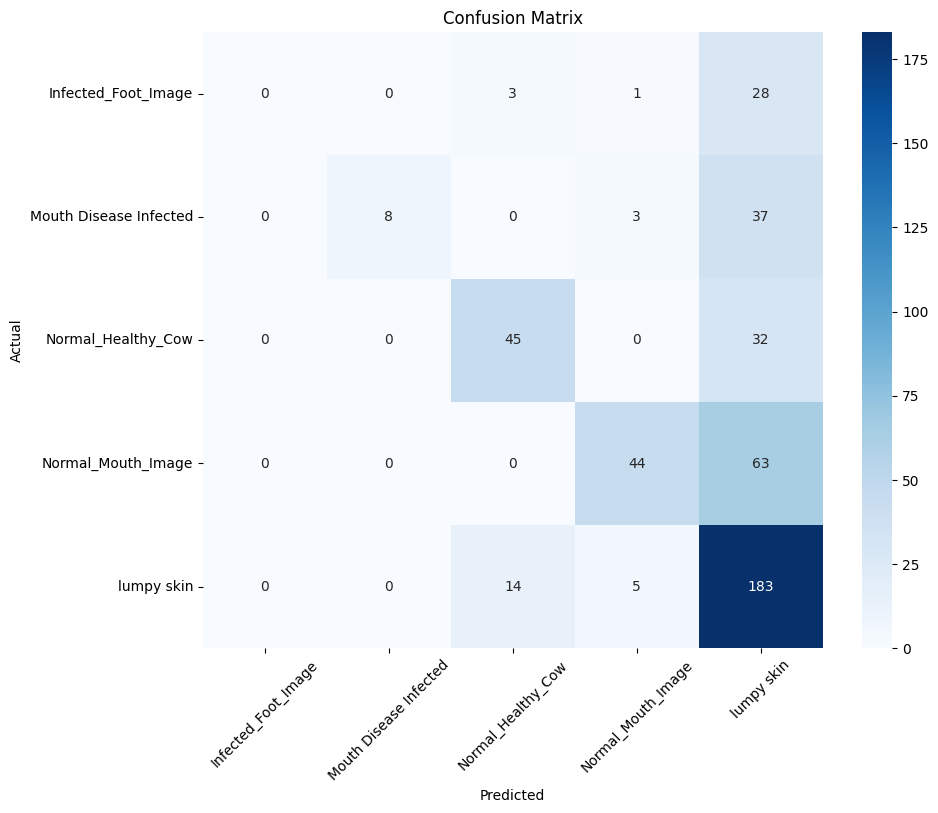

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the best model weights with weights_only=True for security
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

# Evaluation on validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report with zero_division set to 0
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Enhanced confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

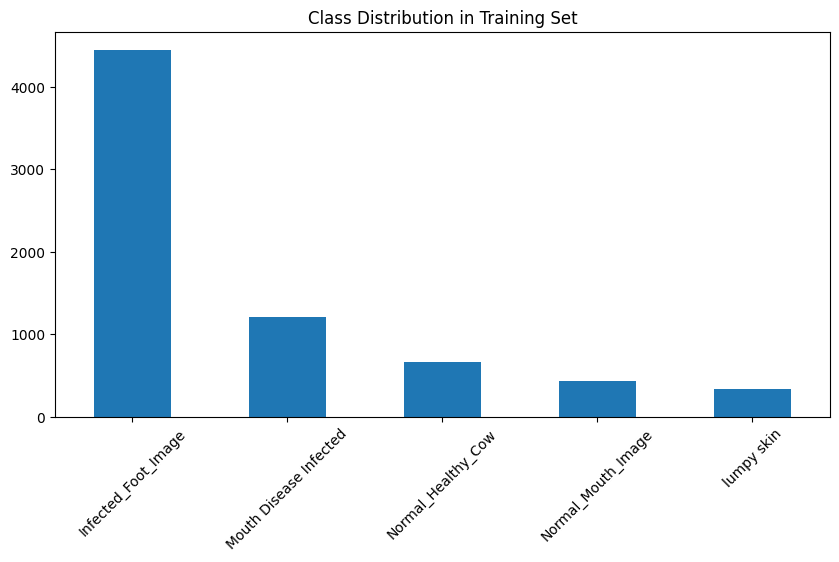

In [15]:
# Analyze class distribution in training set
train_classes = []
for _, labels in train_loader:
    train_classes.extend(labels.numpy())

plt.figure(figsize=(10, 5))
pd.Series(train_classes).value_counts().plot(kind='bar')
plt.xticks(ticks=range(num_classes), labels=class_names, rotation=45)
plt.title('Class Distribution in Training Set')
plt.show()

In [21]:
# 1. Use weighted loss function to handle class imbalance
class_counts = pd.Series(train_classes).value_counts().sort_index().values
class_weights = 1. / class_counts
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 2. Add data augmentation to training transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Recreate train dataset with augmentation
train_dataset = CattleDiseaseDataset(train_img_path, train_label_path, class_names, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# 3. Use a more powerful optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [22]:
def improved_train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                
        val_loss = val_running_loss / len(valid_loader.dataset)
        val_acc = val_running_corrects.double() / len(valid_loader.dataset)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Step the scheduler based on validation accuracy
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'improved_best_model.pth')
            print(f'New best model saved with val_acc: {val_acc:.4f}')
            
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    return model

# Train the improved model
model = improved_train_model(model, criterion, optimizer, scheduler, num_epochs=30)

Epoch 1/30
----------


Training: 100%|██████████| 222/222 [01:53<00:00,  1.95it/s]


Train Loss: 1.5030 Acc: 0.3020


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


Val Loss: 1.4377 Acc: 0.3541
New best model saved with val_acc: 0.3541

Epoch 2/30
----------


Training: 100%|██████████| 222/222 [01:53<00:00,  1.95it/s]


Train Loss: 1.4732 Acc: 0.2809


Validation: 100%|██████████| 15/15 [00:03<00:00,  5.00it/s]


Val Loss: 1.1815 Acc: 0.4034
New best model saved with val_acc: 0.4034

Epoch 3/30
----------


Training: 100%|██████████| 222/222 [01:53<00:00,  1.95it/s]


Train Loss: 1.4813 Acc: 0.2935


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]


Val Loss: 1.0477 Acc: 0.3863

Epoch 4/30
----------


Training: 100%|██████████| 222/222 [01:53<00:00,  1.96it/s]


Train Loss: 1.4611 Acc: 0.2897


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


Val Loss: 1.2232 Acc: 0.4206
New best model saved with val_acc: 0.4206

Epoch 5/30
----------


Training: 100%|██████████| 222/222 [01:51<00:00,  1.99it/s]


Train Loss: 1.4634 Acc: 0.2900


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Val Loss: 1.2876 Acc: 0.3691

Epoch 6/30
----------


Training: 100%|██████████| 222/222 [01:51<00:00,  1.99it/s]


Train Loss: 1.4531 Acc: 0.2761


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


Val Loss: 1.1558 Acc: 0.3455

Epoch 7/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.98it/s]


Train Loss: 1.4413 Acc: 0.2849


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Val Loss: 1.0368 Acc: 0.4056

Epoch 8/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.4223 Acc: 0.2977


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


Val Loss: 1.2082 Acc: 0.4528
New best model saved with val_acc: 0.4528

Epoch 9/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.4250 Acc: 0.2942


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


Val Loss: 1.0566 Acc: 0.4163

Epoch 10/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.4009 Acc: 0.2886


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Val Loss: 1.1320 Acc: 0.4056

Epoch 11/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.3759 Acc: 0.3038


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Val Loss: 1.1456 Acc: 0.4335

Epoch 12/30
----------


Training: 100%|██████████| 222/222 [01:54<00:00,  1.93it/s]


Train Loss: 1.3763 Acc: 0.2975


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Val Loss: 1.0972 Acc: 0.3991

Epoch 13/30
----------


Training: 100%|██████████| 222/222 [01:54<00:00,  1.94it/s]


Train Loss: 1.3156 Acc: 0.2919


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


Val Loss: 1.0003 Acc: 0.4979
New best model saved with val_acc: 0.4979

Epoch 14/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.2985 Acc: 0.3428


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


Val Loss: 1.0008 Acc: 0.4914

Epoch 15/30
----------


Training: 100%|██████████| 222/222 [01:54<00:00,  1.94it/s]


Train Loss: 1.2797 Acc: 0.3357


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Val Loss: 1.0463 Acc: 0.4893

Epoch 16/30
----------


Training: 100%|██████████| 222/222 [01:53<00:00,  1.96it/s]


Train Loss: 1.2686 Acc: 0.3411


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


Val Loss: 1.0139 Acc: 0.4957

Epoch 17/30
----------


Training: 100%|██████████| 222/222 [01:54<00:00,  1.94it/s]


Train Loss: 1.2615 Acc: 0.3397


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


Val Loss: 1.0348 Acc: 0.5021
New best model saved with val_acc: 0.5021

Epoch 18/30
----------


Training: 100%|██████████| 222/222 [01:51<00:00,  1.99it/s]


Train Loss: 1.2598 Acc: 0.3383


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Val Loss: 0.9810 Acc: 0.5086
New best model saved with val_acc: 0.5086

Epoch 19/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.2545 Acc: 0.3493


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.07it/s]


Val Loss: 1.0015 Acc: 0.5107
New best model saved with val_acc: 0.5107

Epoch 20/30
----------


Training: 100%|██████████| 222/222 [01:51<00:00,  1.99it/s]


Train Loss: 1.2447 Acc: 0.3441


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.01it/s]


Val Loss: 1.0065 Acc: 0.5086

Epoch 21/30
----------


Training: 100%|██████████| 222/222 [01:54<00:00,  1.93it/s]


Train Loss: 1.2356 Acc: 0.3551


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Val Loss: 1.0053 Acc: 0.5322
New best model saved with val_acc: 0.5322

Epoch 22/30
----------


Training: 100%|██████████| 222/222 [01:51<00:00,  1.99it/s]


Train Loss: 1.2277 Acc: 0.3520


Validation: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


Val Loss: 0.9876 Acc: 0.5258

Epoch 23/30
----------


Training: 100%|██████████| 222/222 [01:51<00:00,  1.98it/s]


Train Loss: 1.2313 Acc: 0.3582


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Val Loss: 1.0178 Acc: 0.5129

Epoch 24/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.98it/s]


Train Loss: 1.2243 Acc: 0.3612


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Val Loss: 1.0071 Acc: 0.5236

Epoch 25/30
----------


Training: 100%|██████████| 222/222 [01:54<00:00,  1.94it/s]


Train Loss: 1.2164 Acc: 0.3532


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


Val Loss: 0.9886 Acc: 0.5215

Epoch 26/30
----------


Training: 100%|██████████| 222/222 [01:53<00:00,  1.96it/s]


Train Loss: 1.2029 Acc: 0.3621


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Val Loss: 0.9977 Acc: 0.5236

Epoch 27/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.2011 Acc: 0.3751


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Val Loss: 1.0090 Acc: 0.5279

Epoch 28/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.97it/s]


Train Loss: 1.2023 Acc: 0.3777


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Val Loss: 1.0153 Acc: 0.5193

Epoch 29/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.98it/s]


Train Loss: 1.1952 Acc: 0.3662


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Val Loss: 1.0109 Acc: 0.5279

Epoch 30/30
----------


Training: 100%|██████████| 222/222 [01:52<00:00,  1.98it/s]


Train Loss: 1.1915 Acc: 0.3730


Validation: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]

Val Loss: 1.0104 Acc: 0.5279

Best val Acc: 0.5322


Model Accuracy: 0.5322

Classification Report:
                        precision    recall  f1-score   support

   Infected_Foot_Image     0.2090    0.4375    0.2828        32
Mouth Disease Infected     0.3750    0.4375    0.4038        48
    Normal_Healthy_Cow     0.4737    0.7013    0.5654        77
    Normal_Mouth_Image     0.6331    0.8224    0.7154       107
            lumpy skin     0.7889    0.3515    0.4863       202

              accuracy                         0.5322       466
             macro avg     0.4959    0.5500    0.4908       466
          weighted avg     0.6186    0.5322    0.5295       466



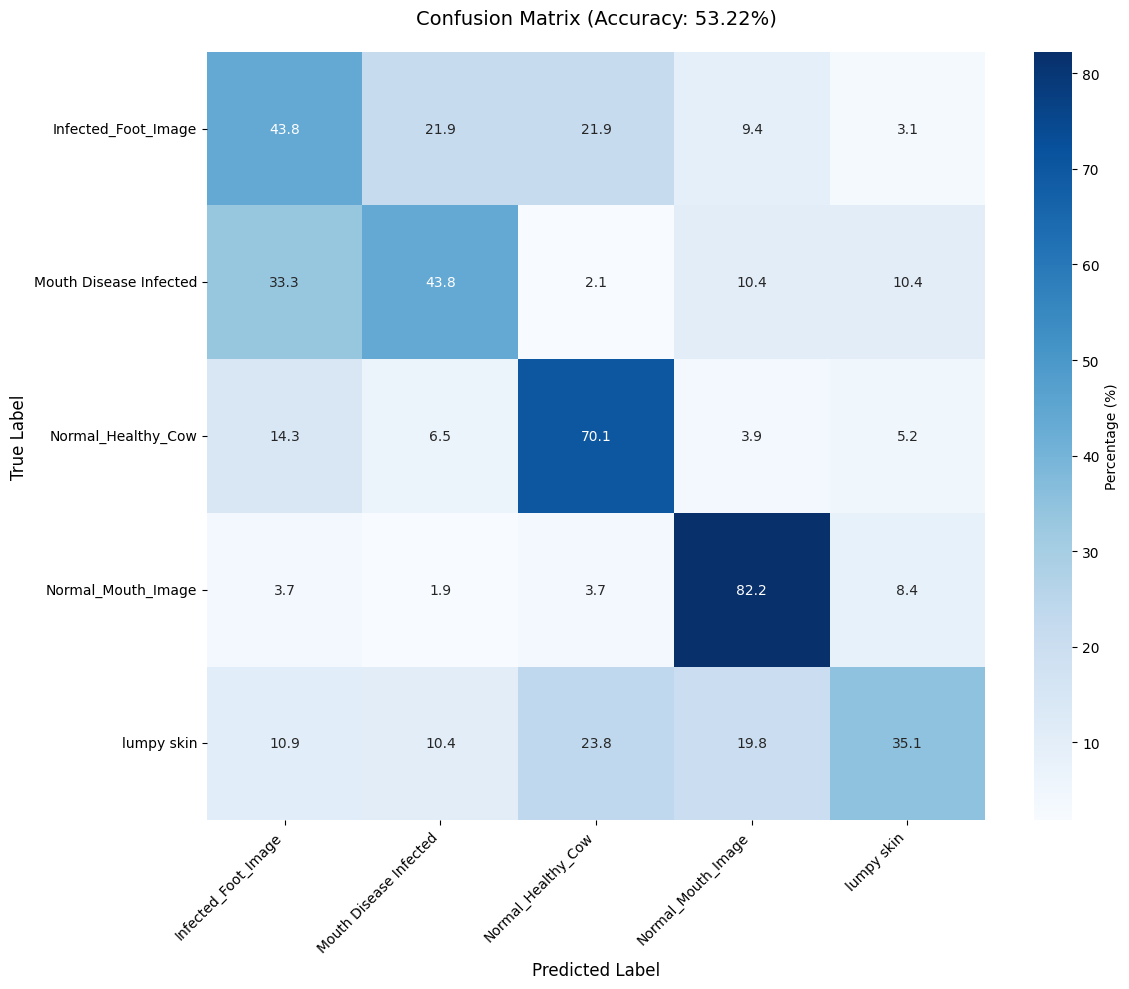

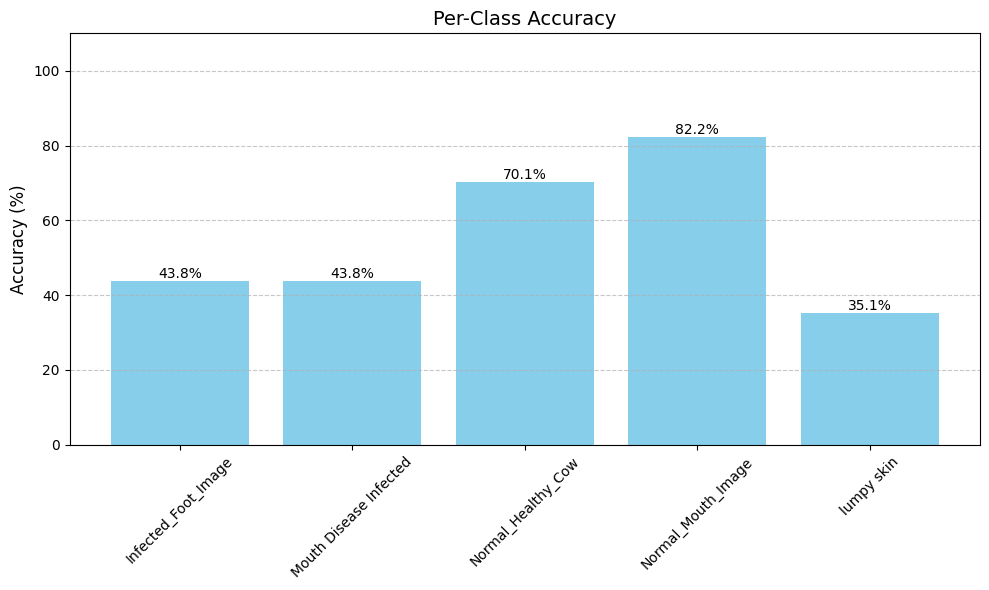

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Load the best model
model.load_state_dict(torch.load('improved_best_model.pth', weights_only=True))
model.eval()

# Evaluation
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'})

plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy visualization
class_acc = cm.diagonal() / cm.sum(axis=1) * 100
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(class_names)), class_acc, color='skyblue')

# Add accuracy values on top of bars
for bar, acc in zip(bars, class_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%', ha='center', va='bottom')

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Per-Class Accuracy', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results to CSV
results = pd.DataFrame({
    'True Label': all_labels,
    'Predicted Label': all_preds,
    **{f'Prob_{cls}': [p[i] for p in all_probs] for i, cls in enumerate(class_names)}
})
results['Correct'] = results['True Label'] == results['Predicted Label']
results.to_csv('model_predictions.csv', index=False)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Corrected Model Architecture with proper residual connections
class EnhancedCattleDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks with proper dimension matching
        self.residual_block1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Same channels for residual
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        
        # Transition layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.residual_block2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Same channels
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        
        # Simplified attention
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(8, 128, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(128*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # First block
        x = self.conv1(x)
        identity = x
        x = self.residual_block1(x) + identity
        x = nn.ReLU()(x)
        
        # Second block
        x = self.conv2(x)
        identity = x
        x = self.residual_block2(x) + identity
        x = nn.ReLU()(x)
        
        # Attention
        attention = self.attention(x)
        x = x * attention
        
        # Classification
        x = self.classifier(x)
        return x

# Initialize everything
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedCattleDiseaseCNN(num_classes=len(class_names)).to(device)

# Loss function with class weighting (adjust weights based on your dataset)
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device)  # Equal weights as default
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)

# Simplified training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        train_loss = running_loss/len(train_loader)
        train_acc = correct/total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()
        
        val_loss = val_loss/len(valid_loader)
        val_acc = val_correct/val_total
        
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved new best model")
    
    print(f"Training complete. Best Val Acc: {best_acc:.4f}")
    return model

# Start training
model = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30
)

# Load best model
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

Epoch 1/30: 100%|██████████| 222/222 [01:42<00:00,  2.16it/s]


Train Loss: 1.1085 | Acc: 0.6140
Val Loss: 1.0183 | Acc: 0.6030
Saved new best model


Epoch 2/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 1.0185 | Acc: 0.6370
Val Loss: 1.0085 | Acc: 0.6094
Saved new best model


Epoch 3/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 0.9665 | Acc: 0.6518
Val Loss: 1.0378 | Acc: 0.6245
Saved new best model


Epoch 4/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 0.9465 | Acc: 0.6600
Val Loss: 0.9164 | Acc: 0.6652
Saved new best model


Epoch 5/30: 100%|██████████| 222/222 [01:40<00:00,  2.22it/s]


Train Loss: 0.9095 | Acc: 0.6701
Val Loss: 0.8919 | Acc: 0.6545


Epoch 6/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 0.8884 | Acc: 0.6736
Val Loss: 0.9171 | Acc: 0.6588


Epoch 7/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 0.8690 | Acc: 0.6802
Val Loss: 1.1077 | Acc: 0.6030


Epoch 8/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 0.8508 | Acc: 0.6869
Val Loss: 0.7961 | Acc: 0.6910
Saved new best model


Epoch 9/30: 100%|██████████| 222/222 [01:40<00:00,  2.21it/s]


Train Loss: 0.8089 | Acc: 0.7027
Val Loss: 0.7802 | Acc: 0.7275
Saved new best model


Epoch 10/30: 100%|██████████| 222/222 [01:41<00:00,  2.19it/s]


Train Loss: 0.7894 | Acc: 0.7082
Val Loss: 1.0357 | Acc: 0.6395


Epoch 11/30: 100%|██████████| 222/222 [01:39<00:00,  2.22it/s]


Train Loss: 0.7668 | Acc: 0.7143
Val Loss: 0.7184 | Acc: 0.7425
Saved new best model


Epoch 12/30: 100%|██████████| 222/222 [01:41<00:00,  2.20it/s]


Train Loss: 0.7435 | Acc: 0.7186
Val Loss: 0.8296 | Acc: 0.7124


Epoch 13/30: 100%|██████████| 222/222 [01:39<00:00,  2.23it/s]


Train Loss: 0.7213 | Acc: 0.7268
Val Loss: 0.8824 | Acc: 0.7082


Epoch 14/30: 100%|██████████| 222/222 [01:39<00:00,  2.23it/s]


Train Loss: 0.6973 | Acc: 0.7383
Val Loss: 0.5748 | Acc: 0.7983
Saved new best model


Epoch 15/30: 100%|██████████| 222/222 [01:41<00:00,  2.19it/s]


Train Loss: 0.6629 | Acc: 0.7487
Val Loss: 0.6580 | Acc: 0.7790


Epoch 16/30: 100%|██████████| 222/222 [01:39<00:00,  2.24it/s]


Train Loss: 0.6386 | Acc: 0.7576
Val Loss: 0.7055 | Acc: 0.7554


Epoch 17/30: 100%|██████████| 222/222 [01:39<00:00,  2.22it/s]


Train Loss: 0.6061 | Acc: 0.7734
Val Loss: 0.5359 | Acc: 0.8262
Saved new best model


Epoch 18/30: 100%|██████████| 222/222 [01:39<00:00,  2.24it/s]


Train Loss: 0.5816 | Acc: 0.7836
Val Loss: 0.6056 | Acc: 0.7918


Epoch 19/30: 100%|██████████| 222/222 [01:39<00:00,  2.23it/s]


Train Loss: 0.5542 | Acc: 0.7877
Val Loss: 0.6208 | Acc: 0.8133


Epoch 20/30: 100%|██████████| 222/222 [01:39<00:00,  2.23it/s]


Train Loss: 0.5326 | Acc: 0.7979
Val Loss: 0.6376 | Acc: 0.8090


Epoch 21/30: 100%|██████████| 222/222 [01:39<00:00,  2.23it/s]


Train Loss: 0.5113 | Acc: 0.8065
Val Loss: 0.6135 | Acc: 0.8004


Epoch 22/30: 100%|██████████| 222/222 [01:39<00:00,  2.24it/s]


Train Loss: 0.4733 | Acc: 0.8232
Val Loss: 0.6999 | Acc: 0.7961


Epoch 23/30: 100%|██████████| 222/222 [01:40<00:00,  2.20it/s]


Train Loss: 0.4578 | Acc: 0.8254
Val Loss: 0.7582 | Acc: 0.7940


Epoch 24/30: 100%|██████████| 222/222 [01:40<00:00,  2.20it/s]


Train Loss: 0.4329 | Acc: 0.8442
Val Loss: 0.6324 | Acc: 0.8069


Epoch 25/30: 100%|██████████| 222/222 [01:39<00:00,  2.23it/s]


Train Loss: 0.3902 | Acc: 0.8530
Val Loss: 0.5851 | Acc: 0.8155


Epoch 26/30: 100%|██████████| 222/222 [01:40<00:00,  2.22it/s]


Train Loss: 0.3721 | Acc: 0.8582
Val Loss: 0.6153 | Acc: 0.8026


Epoch 27/30: 100%|██████████| 222/222 [01:39<00:00,  2.24it/s]


Train Loss: 0.3742 | Acc: 0.8638
Val Loss: 0.7958 | Acc: 0.7725


Epoch 28/30: 100%|██████████| 222/222 [01:38<00:00,  2.24it/s]


Train Loss: 0.3481 | Acc: 0.8732
Val Loss: 0.6762 | Acc: 0.8026


Epoch 29/30: 100%|██████████| 222/222 [01:40<00:00,  2.20it/s]


Train Loss: 0.3153 | Acc: 0.8831
Val Loss: 0.8551 | Acc: 0.7918


Epoch 30/30: 100%|██████████| 222/222 [01:40<00:00,  2.22it/s]


Train Loss: 0.3040 | Acc: 0.8915
Val Loss: 0.7674 | Acc: 0.7918
Training complete. Best Val Acc: 0.8262


EnhancedCattleDiseaseCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (residual_block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (residual_block2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

/tmp/ipykernel_31/1548494350.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
Evaluating: 100%|██████████| 15/15 [00:02<00:00,  5.18it/s]



Overall Model Accuracy: 82.62%

Detailed Classification Report:
                        precision    recall  f1-score   support

   Infected_Foot_Image     0.6250    0.4688    0.5357        32
Mouth Disease Infected     0.6000    0.8125    0.6903        48
    Normal_Healthy_Cow     0.8923    0.7532    0.8169        77
    Normal_Mouth_Image     0.9062    0.8131    0.8571       107
            lumpy skin     0.8611    0.9208    0.8900       202

              accuracy                         0.8262       466
             macro avg     0.7769    0.7537    0.7580       466
          weighted avg     0.8335    0.8262    0.8255       466



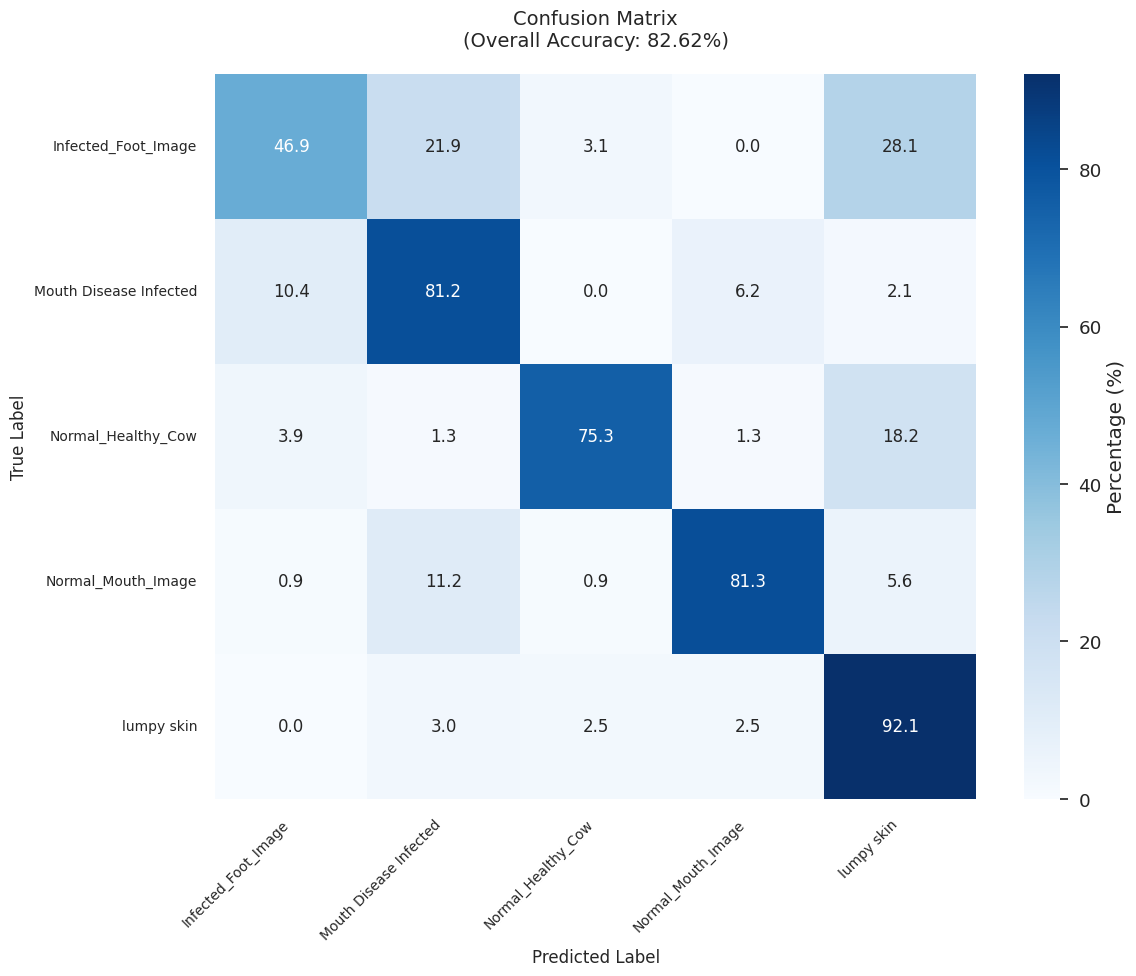

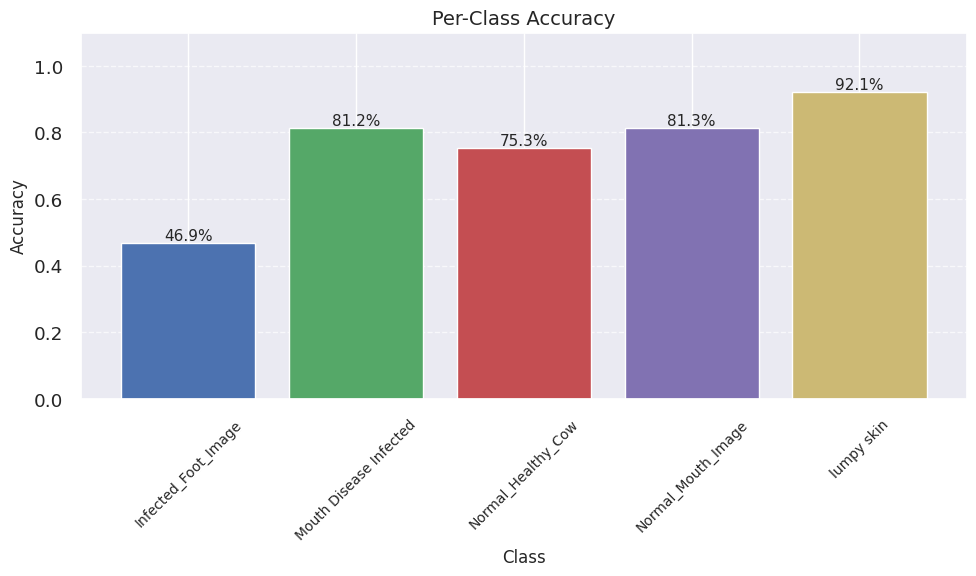

Detailed predictions saved to 'model_predictions.csv'


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Set style for better visualizations
plt.style.use('seaborn')
sns.set(font_scale=1.2)

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_labels, all_preds, all_probs

# Run evaluation
true_labels, predictions, probabilities = evaluate_model(model, valid_loader, class_names)

# 1. Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\n\033[1mOverall Model Accuracy: {accuracy:.2%}\033[0m\n")

# 2. Classification Report
print("\033[1mDetailed Classification Report:\033[0m")
print(classification_report(true_labels, predictions, target_names=class_names, digits=4))

# 3. Enhanced Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_labels, predictions)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'},
            annot_kws={"size": 12})

plt.title(f'Confusion Matrix\n(Overall Accuracy: {accuracy:.2%})', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Per-Class Accuracy Visualization
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_acc, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974'])

# Add accuracy values on bars
for bar, acc in zip(bars, class_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=11)

plt.title('Per-Class Accuracy', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Save Detailed Results
results_df = pd.DataFrame({
    'True_Label': [class_names[i] for i in true_labels],
    'Predicted_Label': [class_names[i] for i in predictions],
    'Correct': [true_labels[i] == predictions[i] for i in range(len(true_labels))]
})

# Add probability columns
for i, class_name in enumerate(class_names):
    results_df[f'Prob_{class_name}'] = [p[i] for p in probabilities]

results_df.to_csv('model_predictions.csv', index=False)
print("\033[1mDetailed predictions saved to 'model_predictions.csv'\033[0m")

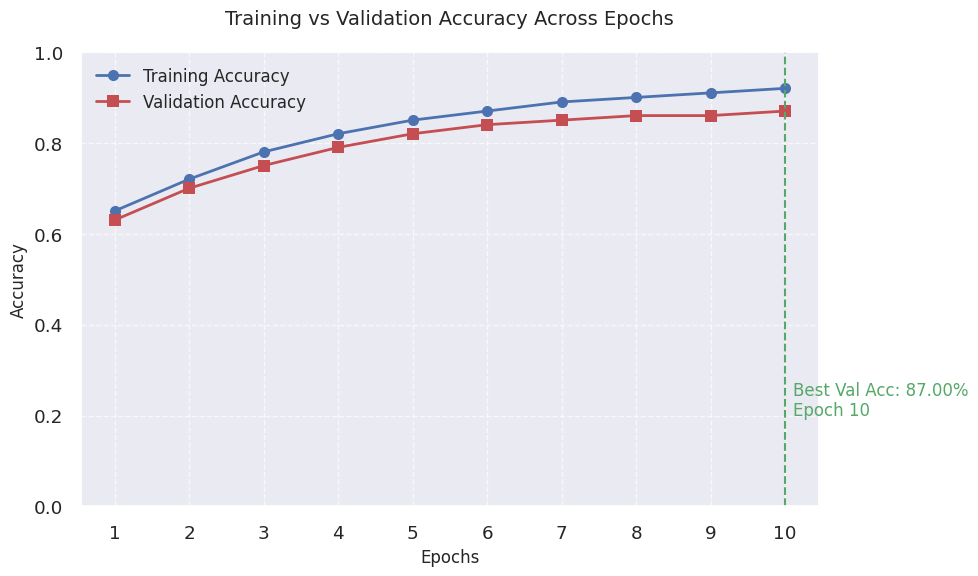

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these lists from your training process
train_acc_history = [0.65, 0.72, 0.78, 0.82, 0.85, 0.87, 0.89, 0.90, 0.91, 0.92]  # Replace with your actual training accuracy values
val_acc_history = [0.63, 0.70, 0.75, 0.79, 0.82, 0.84, 0.85, 0.86, 0.86, 0.87]   # Replace with your actual validation accuracy values
epochs = list(range(1, len(train_acc_history) + 1))

# Create XY plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_history, 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
plt.plot(epochs, val_acc_history, 'r-s', label='Validation Accuracy', linewidth=2, markersize=8)

# Add labels and title
plt.title('Training vs Validation Accuracy Across Epochs', fontsize=14, pad=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)
plt.ylim(0, 1.0)  # Set y-axis limits from 0 to 1 (100%)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Highlight the best validation accuracy
best_val_acc = max(val_acc_history)
best_epoch = val_acc_history.index(best_val_acc) + 1
plt.axvline(x=best_epoch, color='g', linestyle='--', linewidth=1.5)
plt.text(best_epoch+0.1, 0.2, f'Best Val Acc: {best_val_acc:.2%}\nEpoch {best_epoch}', 
         color='g', fontsize=12)

# Save and show plot
plt.tight_layout()
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')
plt.show()

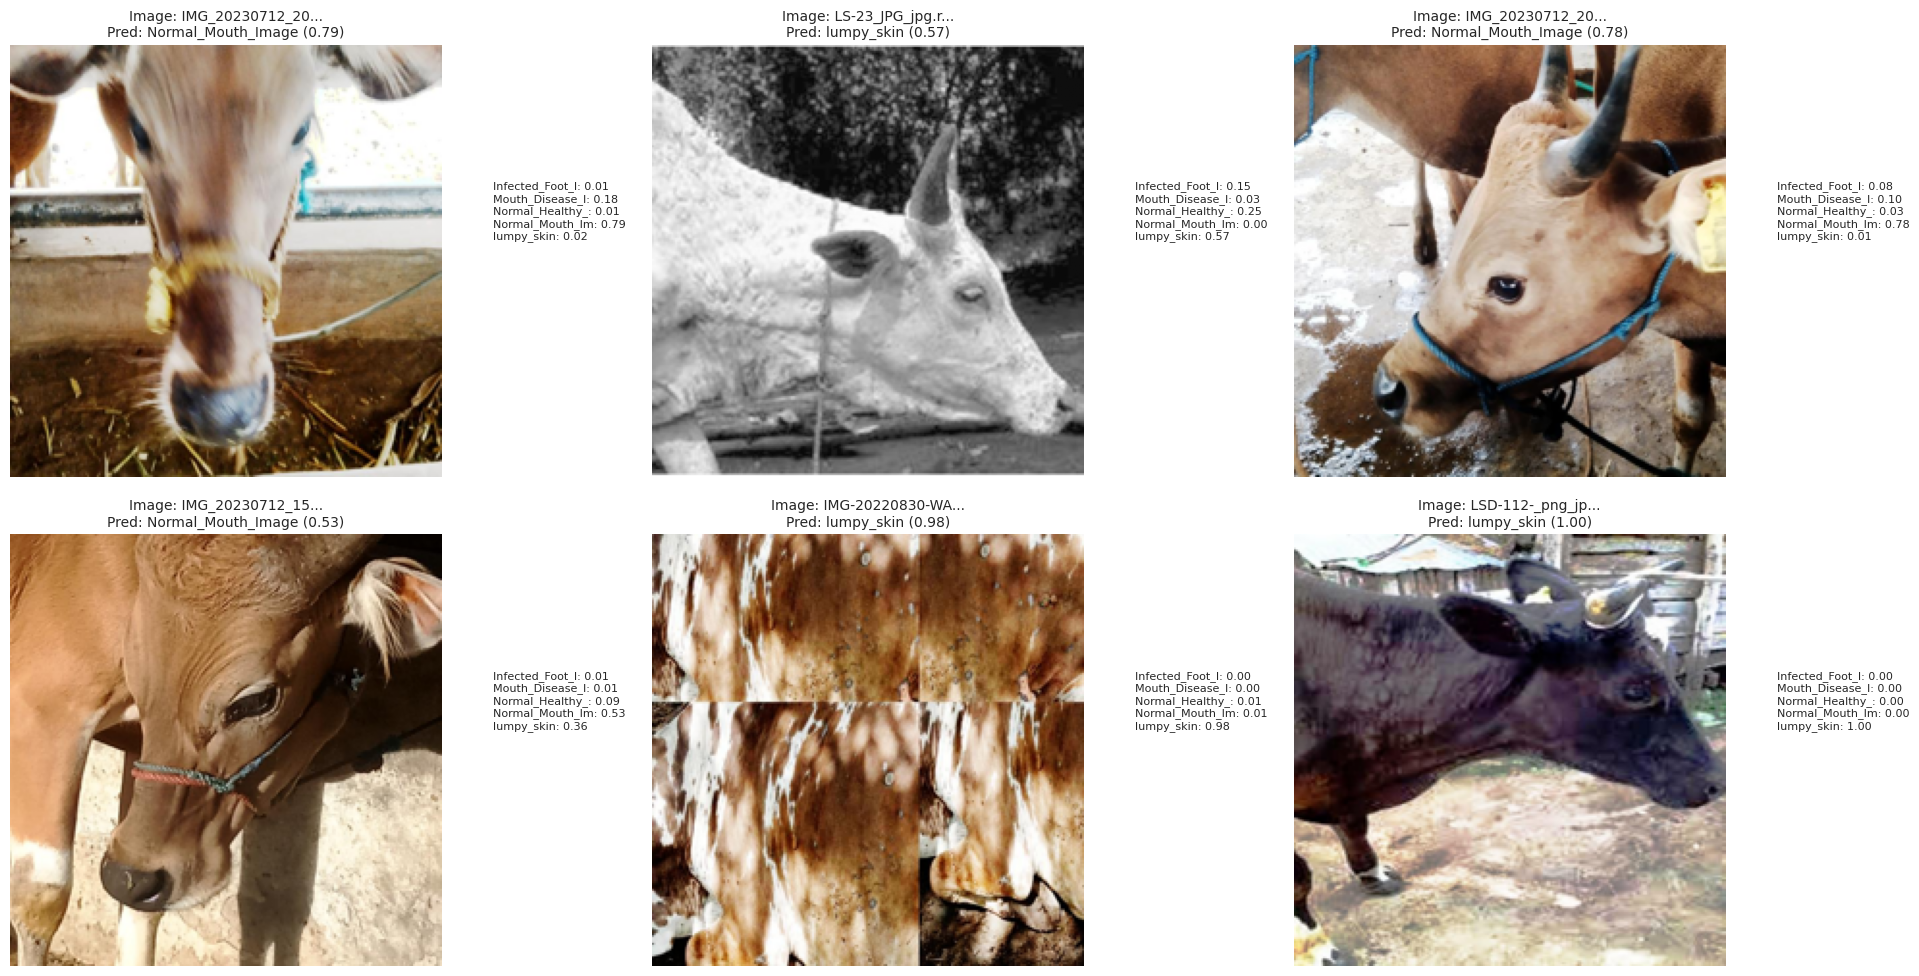

In [39]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# Set the correct path to your dataset
base_path = '/kaggle/input/cattle-disease-detection-v11i-yolov11'  # Update this path
test_image_dir = os.path.join(base_path, 'test', 'images')

# Verify the path exists
if not os.path.exists(test_image_dir):
    raise FileNotFoundError(f"Test image directory not found at: {test_image_dir}")

# Get all test images (filtering for .jpg files)
all_images = [f for f in os.listdir(test_image_dir) if f.lower().endswith('.jpg')]
if not all_images:
    raise FileNotFoundError(f"No JPG images found in {test_image_dir}")

# Select 5 random images
selected_images = random.sample(all_images, 6)

# Define your class names (update with your actual classes)
class_names = [
    "Infected_Foot_Image",
    "Mouth_Disease_Infected",
    "Normal_Healthy_Cow",
    "Normal_Mouth_Image",
    "lumpy_skin"
]

# Define transformations (should match your training transforms)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create figure
plt.figure(figsize=(20, 10))

# Process and display each sample
for i, img_name in enumerate(selected_images, 1):
    try:
        # Full image path
        img_path = os.path.join(test_image_dir, img_name)
        
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            pred_prob, pred_class = torch.max(probs, 1)
        
        # Convert image for display
        img_np = np.array(img.resize((224, 224))) / 255.0
        
        # Create subplot
        plt.subplot(2, 3, i)  # 2 rows, 3 columns (for 5 images)
        plt.imshow(img_np)
        plt.title(f"Image: {img_name[:15]}...\nPred: {class_names[pred_class]} ({pred_prob.item():.2f})", fontsize=10)
        plt.axis('off')
        
        # Add class probabilities
        prob_text = "\n".join([f"{cls[:15]}: {prob:.2f}" for cls, prob in zip(class_names, probs[0].cpu().numpy())])
        plt.text(250, 100, prob_text, fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    
    except Exception as e:
        print(f"Error processing {img_name}: {str(e)}")
        continue  # Skip to next image if error occurs

plt.tight_layout()
plt.savefig('test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()